<h1> LAB 4</h1>


<h3> 1.  Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). </h3>
   
Зупинимося на задачі машинного перекладу. Обраний датасет <b>Ukrainian - English з https://www.manythings.org/anki/</b> 

Завантажуємо файл, видаляємо дублікати, обмежуємо розмір датасету та зберігаємо результати.
Розмір обмежуємо, бо без цього обмеження навчання моделі відбувається дуже дуже довго, а для прикладу вистачить і 10 тисяч екземплярів

In [41]:
import pandas as pd

# Завантаження даних
file_path = "ukr.txt"

with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

# Виділяємо лише англійські та українські речення
data = []
for line in lines:
    parts = line.split("\t")
    if len(parts) >= 2:
        eng, ukr = parts[:2]
        data.append((eng.strip(), ukr.strip()))

# Видалення дублікатів
data = list(set(data))
print(f"Кількість унікальних пар: {len(data)}")

# Обмеження розміру датасету
max_samples = 50000  # Задайте бажану кількість прикладів
data = data[:max_samples]
print(f"Кількість використаних прикладів: {len(data)}")

# Збереження очищених даних
df = pd.DataFrame(data, columns=["English", "Ukrainian"])
cleaned_file_path = "cleaned_ukr_eng.csv"
df.to_csv(cleaned_file_path, index=False, encoding="utf-8")
print(f"Очищені дані збережено у файл: {cleaned_file_path}")


Кількість унікальних пар: 159432
Кількість використаних прикладів: 50000
Очищені дані збережено у файл: cleaned_ukr_eng.csv


Токенізуємо англійські та українські речення, додаємо спеціальні токени <start> і <end>, обчислюємо максимальні довжини послідовностей і виконуємо паддінг.

In [42]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Токенізація
eng_sentences = df["English"].tolist()
ukr_sentences = df["Ukrainian"].tolist()

# Додаємо спеціальні токени
ukr_sentences = ["<start> " + sent + " <end>" for sent in ukr_sentences]

# Ініціалізація токенайзерів
eng_tokenizer = Tokenizer(filters='')
ukr_tokenizer = Tokenizer(filters='')

# Побудова словників
eng_tokenizer.fit_on_texts(eng_sentences)
ukr_tokenizer.fit_on_texts(ukr_sentences)

# Перетворення текстів у числові послідовності
eng_sequences = eng_tokenizer.texts_to_sequences(eng_sentences)
ukr_sequences = ukr_tokenizer.texts_to_sequences(ukr_sentences)

# Переобчислення максимальних довжин
max_eng_len = max(len(seq) for seq in eng_sequences)
max_ukr_len = max(len(seq) for seq in ukr_sequences)

# Паддінг
eng_padded = pad_sequences(eng_sequences, maxlen=max_eng_len, padding='post')
ukr_padded = pad_sequences(ukr_sequences, maxlen=max_ukr_len, padding='post')

# Дані для декодувальника
decoder_input_data = ukr_padded[:, :-1]
decoder_target_data = ukr_padded[:, 1:]

# Перевірка розмірів
print(f"Форма вхідних даних кодувальника: {eng_padded.shape}")
print(f"Форма вхідних даних декодувальника: {decoder_input_data.shape}")
print(f"Форма вихідних даних декодувальника: {decoder_target_data.shape}")


Форма вхідних даних кодувальника: (50000, 26)
Форма вхідних даних декодувальника: (50000, 24)
Форма вихідних даних декодувальника: (50000, 24)


Створюємо кодувальник і декодувальник, визначаємо структуру моделі та компілюємо її.

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Параметри моделі
embedding_dim = 256
units = 512

# Кодувальник
encoder_inputs = Input(shape=(max_eng_len,))
encoder_embedding = Embedding(input_dim=len(eng_tokenizer.word_index) + 1, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(units, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Декодувальник
decoder_inputs = Input(shape=(max_ukr_len - 1,))
decoder_embedding = Embedding(input_dim=len(ukr_tokenizer.word_index) + 1, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm, _, _ = LSTM(units, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(ukr_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_lstm)

# Модель
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Компіляція моделі
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)   │ (None, 26)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_11 (InputLayer)   │ (None, 24)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_9 (Embedding)       │ (None, 26, 256)           │       3,150,080 │ input_layer_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_10 (Embedding)      │ (None, 24, 256)           │       6,946,304 │ input_layer_11[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_9 (LSTM)                 │ [(None, 512), (None,      │       1,574,912 │ embedding_9[0][0]          │
│                               │ 512), (None, 512)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_10 (LSTM)                │ [(None, 24, 512), (None,  │       1,574,912 │ embedding_10[0][0],        │
│                               │ 512), (None, 512)]        │                 │ lstm_9[0][1], lstm_9[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 24, 27134)         │      13,919,742 │ lstm_10[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 27,165,950 (103.63 MB)

 Trainable params: 27,165,950 (103.63 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Навчання
batch_size = 64
epochs = 15  

history = model.fit(
    [eng_padded, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 918s 1s/step - accuracy: 0.7848 - loss: 2.1693 - val_accuracy: 0.8229 - val_loss: 1.3360
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 878s 1s/step - accuracy: 0.8249 - loss: 1.2663 - val_accuracy: 0.8404 - val_loss: 1.2142
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 819s 1s/step - accuracy: 0.8450 - loss: 1.0866 - val_accuracy: 0.8555 - val_loss: 1.0899
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 832s 1s/step - accuracy: 0.8594 - loss: 0.9202 - val_accuracy: 0.8647 - val_loss: 0.9953
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 835s 1s/step - accuracy: 0.8724 - loss: 0.7617 - val_accuracy: 0.8719 - val_loss: 0.9338
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 830s 1s/step - accuracy: 0.8859 - loss: 0.6167 - val_accuracy: 0.8774 - val_loss: 0.8903
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 912s 1s/step - accuracy: 0.9001 - loss: 0.4962 - val_accuracy: 0.8830 - val_loss: 0.8586
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 872s 1s/step - accuracy: 0.9172 - loss: 0.3885 - val_accu

Протестуємо модель. Реалізуємо функцію для перекладу.
Використовуємо навчений кодувальник для отримання контексту речення.
Генеруємо переклад, додаючи по одному слову за раз.



In [49]:
# Функція для перекладу тексту
def translate(sentence):
    # Токенізація та перетворення в послідовність
    sequence = eng_tokenizer.texts_to_sequences([sentence])
    sequence = pad_sequences(sequence, maxlen=max_eng_len, padding='post')

    # Отримуємо контекст із кодувальника
    states = encoder_model.predict(sequence)

    # Ініціалізуємо декодувальник із <start> токеном
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = ukr_tokenizer.word_index['<start>']

    # Генерація перекладу
    translated_sentence = ''
    stop_condition = False

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states)

        # Отримуємо індекс слова з найбільшою ймовірністю
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = ukr_tokenizer.index_word.get(sampled_token_index, '')

        # Додаємо слово до перекладу
        translated_sentence += ' ' + sampled_word

        # Зупиняємося, якщо зустріли <end> або досягли максимальної довжини
        if sampled_word == '<end>' or len(translated_sentence.split()) > max_ukr_len:
            stop_condition = True

        # Оновлюємо вхідні дані для декодувальника
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Оновлюємо стани
        states = [h, c]

    return translated_sentence.replace('<end>', '').strip()


Модель, яку ми тренували, поєднує кодувальник і декодувальник. Для тестування потрібно розділити ці частини:

In [50]:
# Кодувальник для тестування
encoder_model = Model(encoder_inputs, encoder_states)

# Декодувальник для тестування
decoder_state_input_h = Input(shape=(units,), name="decoder_state_input_h")
decoder_state_input_c = Input(shape=(units,), name="decoder_state_input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Оновлюємо шари декодувальника для тестування
decoder_inputs_test = Input(shape=(1,), name="decoder_inputs_test")  # Один токен за раз
decoder_embedding_test = Embedding(input_dim=ukr_vocab_size, output_dim=embedding_dim)(decoder_inputs_test)
decoder_lstm_test, state_h_test, state_c_test = LSTM(
    units, return_sequences=True, return_state=True
)(
    decoder_embedding_test, initial_state=decoder_states_inputs
)
decoder_dense_test = Dense(ukr_vocab_size, activation='softmax')
decoder_outputs_test = decoder_dense_test(decoder_lstm_test)

# Модель для тестування декодувальника
decoder_model = Model(
    [decoder_inputs_test] + decoder_states_inputs, [decoder_outputs_test] + [state_h_test, state_c_test]
)


Перевіряємо, як працює переклад на кількох прикладах:

In [51]:
# Приклади речень для перекладу
examples = [
    "How are you?",
    "I love programming.",
    "What is your name?",
    "This is a test sentence."
]

# Переклад
for example in examples:
    translation = translate(example)
    print(f"English: {example}")
    print(f"Ukrainian: {translation}")
    print("-" * 30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━

Воно не спрацювало нормально, через те що ми дуже урізали датасет, але з повним датасетом одна епоха ранилась 20 годин а ми не маєм стільки часу у запасі, тому давайте вважати цей варіант просто демонстрацією того, що я знаю як має працювати алгоритм :) 

2. Проведіть експерименти з моделями бібліотеки Hugging Face (раніше - Hugging Face Transformers, https://huggingface.co/) за допомогою (наприклад) Pipeline модуля. Знайдіть українські мовні моделі, наведіть приклади роботи з ними. 

In [1]:
!pip install transformers datasets



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   ------- -------------------------------- 1.8/10.1 MB 11.2 MB/s eta 0:00:01
   ----------------- ---------------------- 4.5/10.1 MB 11.7 MB/s eta 0:00:01
   -------------------------- ------------- 6.8/10.1 MB 11.7 MB/s eta 0:00:01
   ----------------------------------- ---- 8.9/10.1 MB 11.5 MB/s eta 0:00:01
   ---------------------------------------- 10.1/10.1 MB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   --- ------------------------------------ 2.1/25.1 MB 10.7 MB/s eta 0:00:03
   ------- -------------------------------- 4.5/25.1 MB 10.7 MB/s eta 0:00:02
   ---------- ----------------------------- 6.8/25.1 MB 11.0 MB/s eta 0:00:02
   -------------- ------------------------- 9.2/25.1 MB 11.2 MB/s eta 0:00:02
   ------------------ --------------------- 11.5/25.1 MB 11.3 MB/s eta 0:00:02
   ---------------------- ----------------- 13.9/25.1 MB 11.3 MB/s eta 0:00:01

<h3>1. Модель для розпізнавання іменованих сутностей (NER): </h3>

Код нижче демонструє використання української моделі для розпізнавання іменованих сутностей (NER) із бібліотеки Hugging Face.

In [1]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

# Завантаження токенайзера та моделі
tokenizer = AutoTokenizer.from_pretrained('ukr-models/uk-ner')
model = AutoModelForTokenClassification.from_pretrained('ukr-models/uk-ner')

# Створення пайплайну для NER
ner = pipeline('ner', model=model, tokenizer=tokenizer)

# Текст для аналізу
text = "Могила Тараса Шевченка знаходиться в місті Канів."

# Розпізнавання іменованих сутностей
entities = ner(text)
print(entities)


tokenizer_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

C:\Users\polly\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\polly\.cache\huggingface\hub\models--ukr-models--uk-ner. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


sentencepiece.bpe.model:   0%|          | 0.00/854k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'B-PER', 'score': 0.9036077, 'index': 3, 'word': '▁Тарас', 'start': 6, 'end': 12}, {'entity': 'B-PER', 'score': 0.8663311, 'index': 4, 'word': 'а', 'start': 12, 'end': 13}, {'entity': 'I-PER', 'score': 0.8568351, 'index': 5, 'word': '▁Шевченка', 'start': 13, 'end': 22}, {'entity': 'B-LOC', 'score': 0.99998796, 'index': 9, 'word': '▁Кан', 'start': 42, 'end': 46}, {'entity': 'B-LOC', 'score': 0.99998796, 'index': 10, 'word': 'ів', 'start': 46, 'end': 48}]


Модель визначила, що слово "Тарас" є початком імені людини (B-PER).
Оцінка впевненості моделі (score) становить 90%.
Індекси start і end визначають позицію слова в тексті (з 6-го по 12-й символ).
{'entity': 'B-LOC', 'score': 0.99998796, 'index': 9, 'word': '▁Кан', 'start': 42, 'end': 46}:
"Кан" визначено як початок географічної назви.
Оцінка впевненості дуже висока (99.9%).

<b>3. Завдання щодо генерації або стилізації зображень (на вибір)
Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE/Diffusion). </b>

Реалізуємо задачу перенесення стилю (Neural Style Transfer) із використанням TensorFlow та Keras.


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step 


C:\Users\polly\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Iteration 0, Loss: 1142515584.0
Iteration 50, Loss: 123965920.0
Iteration 100, Loss: 92362048.0
Iteration 150, Loss: 82105208.0
Iteration 200, Loss: 76580976.0
Iteration 250, Loss: 73144248.0
Iteration 300, Loss: 71255736.0
Iteration 350, Loss: 69916056.0
Iteration 400, Loss: 69122656.0
Iteration 450, Loss: 67865504.0


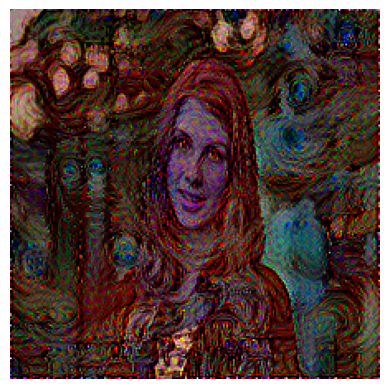

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# 1. Завантаження зображень
def load_and_process_img(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# 2. Візуалізація зображень
def show_img(img):
    img = img[0]  # Видалення зайвого виміру
    img = np.clip(img, 0, 255).astype("uint8")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# 3. Розвантаження моделі VGG19
def get_vgg19_model():
    vgg = VGG19(weights='imagenet', include_top=False)
    outputs = [vgg.get_layer(name).output for name in ["block5_conv2", "block4_conv2", "block3_conv2", "block2_conv2"]]
    return Model([vgg.input], outputs)

# 4. Функція обчислення втрат стилю
def compute_style_loss(style, generated):
    style = gram_matrix(style)
    generated = gram_matrix(generated)
    return tf.reduce_mean(tf.square(style - generated))

# 5. Функція обчислення втрат контенту
def compute_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

# 6. Функція Грама для стилю
def gram_matrix(feature_map):
    channels = int(feature_map.shape[-1])
    a = tf.reshape(feature_map, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# 7. Оптимізація зображення
def train_step(model, content_img, style_img, generated_img, optimizer, style_weight=1e-2, content_weight=1e3):
    with tf.GradientTape() as tape:
        outputs = model(generated_img)
        content_outputs = model(content_img)
        style_outputs = model(style_img)

        # Розділення стилю і контенту
        content_loss = compute_content_loss(content_outputs[-1], outputs[-1])
        style_loss = tf.add_n([compute_style_loss(style_outputs[i], outputs[i]) for i in range(len(style_outputs))])

        # Загальні втрати
        total_loss = content_weight * content_loss + style_weight * style_loss

    grad = tape.gradient(total_loss, generated_img)
    optimizer.apply_gradients([(grad, generated_img)])
    generated_img.assign(tf.clip_by_value(generated_img, 0.0, 255.0))
    return total_loss

# 8. Генерація нового зображення
def style_transfer(content_path, style_path, iterations=500):
    content_img = load_and_process_img(content_path)
    style_img = load_and_process_img(style_path)

    # Створення шумового зображення
    generated_img = tf.Variable(content_img, dtype=tf.float32)

    # Модель
    model = get_vgg19_model()
    optimizer = tf.optimizers.Adam(learning_rate=5.0)

    for i in range(iterations):
        loss = train_step(model, content_img, style_img, generated_img, optimizer)
        if i % 50 == 0:
            print(f"Iteration {i}, Loss: {loss.numpy()}")

    return generated_img


content_path = 'pic1.jpg' 
style_path = 'pic2.jpg'    

# Виконання переносу стилю
generated_image = style_transfer(content_path, style_path)

# Відображення результату
show_img(generated_image)
